In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import geoutils as gu
import xdem

from ragmac_xdem import plotting, utils, files, temporal, io

import warnings
warnings.filterwarnings('ignore')

## Experiment 2
- Process all ASTER dems
- Use co-registered DEMs produced with scripts/main_experiment2.py -c PK_Baltoro -run CTL -mode TimeSeries
 
### In this notebook
- Load and stack DEMs with xarray
- Load glacier outline
- Load OGGM center flowline
- Select points along center flowline
- Evaluate linear regression and GPR fits to selected points

### Gather files

In [3]:
input_dir = '../data/processed/experiment_2/PK_Baltoro/coreg1_filter1/'
dem_files_list = sorted(glob.glob(os.path.join(input_dir, '*coreg.tif')))

### Parse dates

In [4]:
datetimes_list = utils.get_dems_date(dem_files_list)
dates_list = [d.date() for d in datetimes_list] # for plotting

### Stack as xarray dataset

In [5]:
reference_dem = '../data/raw/experiment_2/PK_Baltoro/PK_Baltoro_Copernicus_REF_DEM.tif'

In [6]:
ds = io.xr_stack_geotifs(dem_files_list,
                         datetimes_list,
                         reference_dem,
                         resampling="bilinear",
                         save_to_nc = False)

In [7]:
ma_stack = np.ma.masked_invalid(ds['band1'].values)

### Plot DEMs

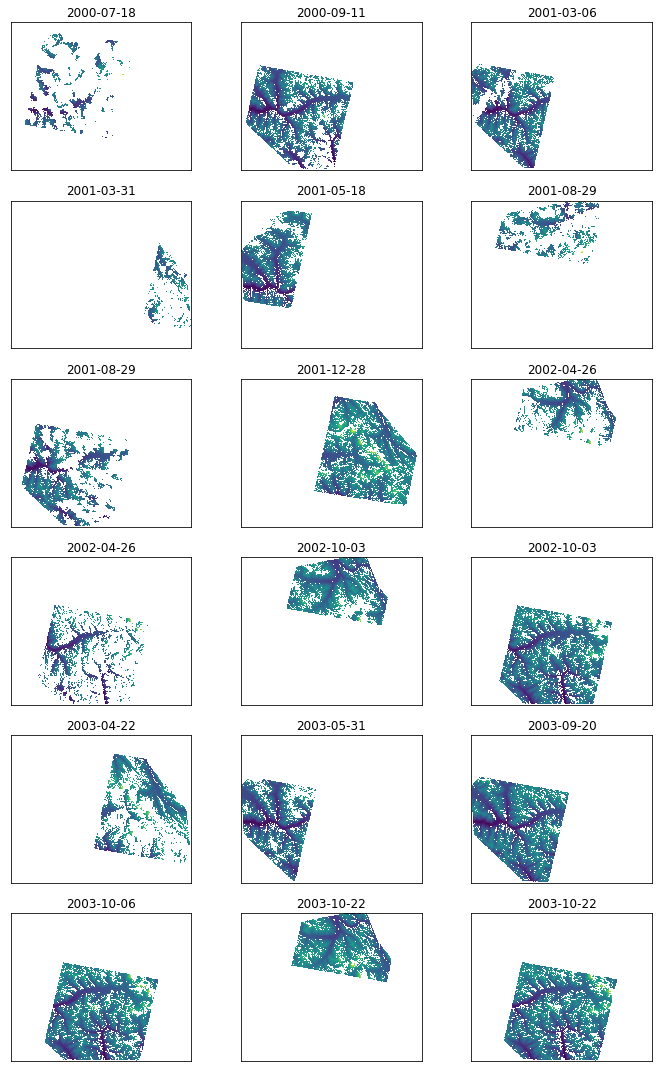

In [8]:
n = 18
plotting.plot_array_gallery(ma_stack[:n], dates_list[:n])

### Create count and standard deviation maps

In [9]:
count = np.ma.count(ma_stack,axis=0)
count = np.ma.masked_where(count==0,count)
std   = np.ma.std(ma_stack,axis=0)

In [10]:
# put count and std arrays into xarray ds container
count_da = ds['band1'].isel(time=0).drop('time')
count_da.values = count
count_da.name = 'count'

std_da = ds['band1'].isel(time=0).drop('time')
std_da.values = std
std_da.name   = 'std'

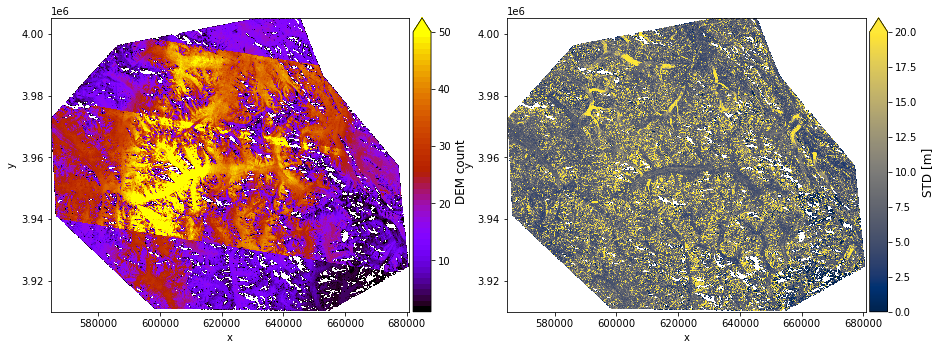

In [11]:
plotting.xr_plot_count_std_glacier(count_da,
                                   std_da)

In [12]:
# get largest glacier outline
fn = '../data/raw/experiment_2/PK_Baltoro/14_rgi60_asw_wgs84_utm43n_baltoro_selection.shp'
glacier_gdf = utils.get_largest_glacier_from_shapefile(fn, crs = ds.rio.crs)

In [13]:
# get center flowlines from OGGM
rgi_id = glacier_gdf['RGIId'].values[0]
flowline_gdf = utils.OGGM_get_centerline(rgi_id, crs = ds.rio.crs)

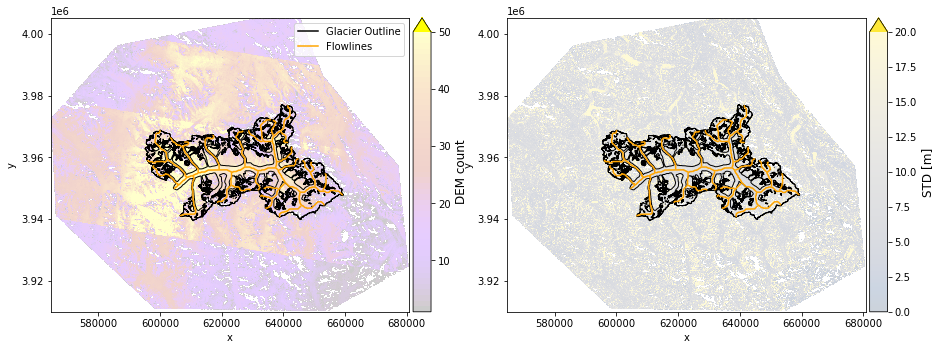

In [14]:
plotting.xr_plot_count_std_glacier(count_da,
                                   std_da,
                                   glacier_gdf,
                                   flowline_gdf,
                                   alpha=0.2)

In [15]:
# get vertices of longest segment
longest_segment = flowline_gdf[flowline_gdf['LE_SEGMENT'] == flowline_gdf['LE_SEGMENT'].max()]
points = utils.extract_linestring_coords(longest_segment['geometry'].iloc[0])

In [16]:
# select every nth point
step = 15
points = [points[0][::step], points[1][::step]]

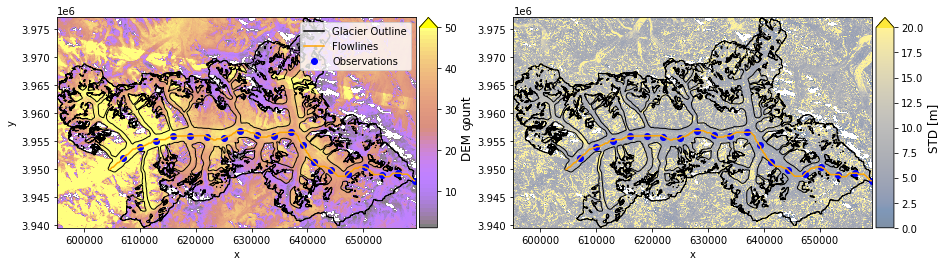

In [17]:
plotting.xr_plot_count_std_glacier(count_da,
                                   std_da,
                                   glacier_gdf,
                                   longest_segment,
                                   points=points,
                                   alpha=0.5,
                                   plot_to_glacier_extent=True)

### Prepare training data

In [18]:
date_time_as_float_array = np.ma.array([utils.date_time_to_decyear(i) for i in datetimes_list]).data
test_stack = utils.xr_extract_ma_arrays_at_coords(ds['band1'], points[0], points[1])

In [19]:
## remove time series where less available measruements than threshold
n_thresh = 5
test_stack, valid_mask = temporal.mask_low_count_pixels(test_stack, n_thresh = n_thresh)
points = [points[0][valid_mask],points[1][valid_mask]]

In [20]:
X_train_data = []
y_train_data = []
for i in range(test_stack.shape[1]):
    X_train, y_train = temporal.remove_nan_from_training_data(date_time_as_float_array, test_stack[:,i])
    
    X_train_data.append(X_train)
    y_train_data.append(y_train)


In [21]:
labels = plotting.float_x_y_to_int_tuple(points[0],points[1])

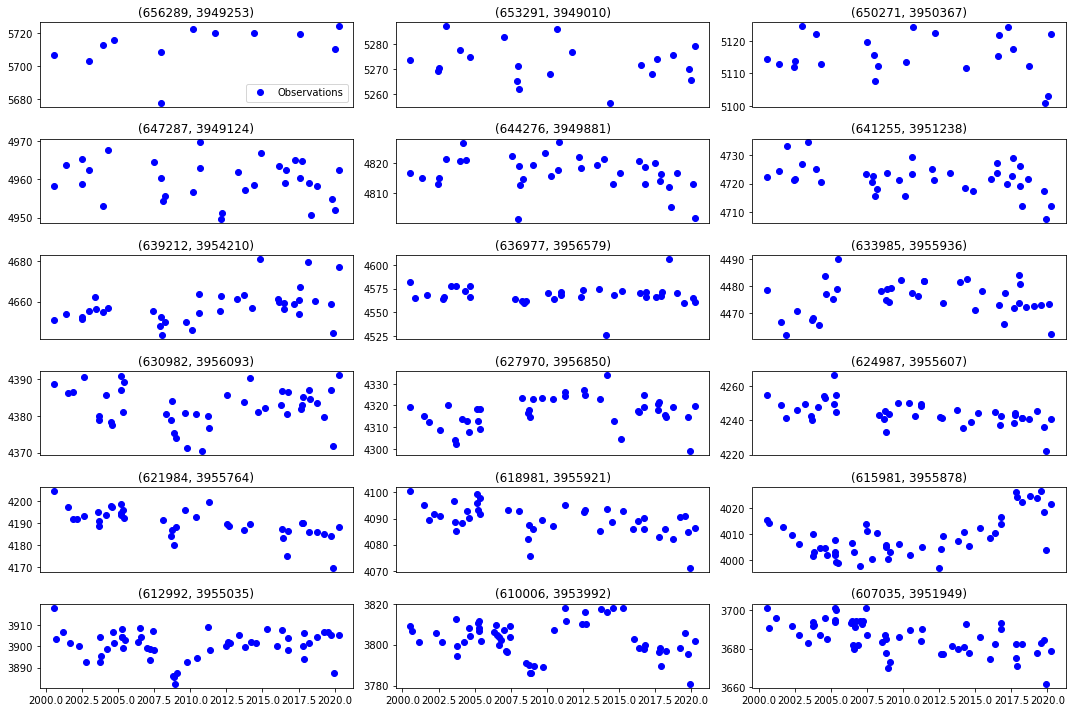

In [22]:
plotting.plot_time_series_gallery(X_train_data,y_train_data, labels = labels)

### Compare linear models

#### Prepare time series along which to make prediction

In [32]:
X = temporal.create_prediction_timeseries(start_date = '2000-01-01',
                                       end_date = '2023-01-01',
                                       dt ='M')

#### Linear regression

In [33]:
predictions = []

for i,v in enumerate(X_train_data):
    slope, intercept = temporal.linreg_fit(X_train_data[i],
                                           y_train_data[i],
                                           method='Linear')
    prediction = slope*X+intercept
    predictions.append(prediction)
    
LinearReg_df = pd.DataFrame(predictions).T
LinearReg_df.index = X

#### RANSAC

In [34]:
predictions = []

for i,v in enumerate(X_train_data):
    slope, intercept = temporal.linreg_fit(X_train_data[i],
                                           y_train_data[i],
                                           method='RANSAC')
    prediction = slope*X+intercept
    predictions.append(prediction)
    
RANSAC_df = pd.DataFrame(predictions).T
RANSAC_df.index = X

#### Theil Sen

In [35]:
predictions = []

for i,v in enumerate(X_train_data):
    slope, intercept = temporal.linreg_fit(X_train_data[i],
                                           y_train_data[i],
                                           method='TheilSen')
    prediction = slope*X+intercept
    predictions.append(prediction)
    
TheilSen_df = pd.DataFrame(predictions).T
TheilSen_df.index = X

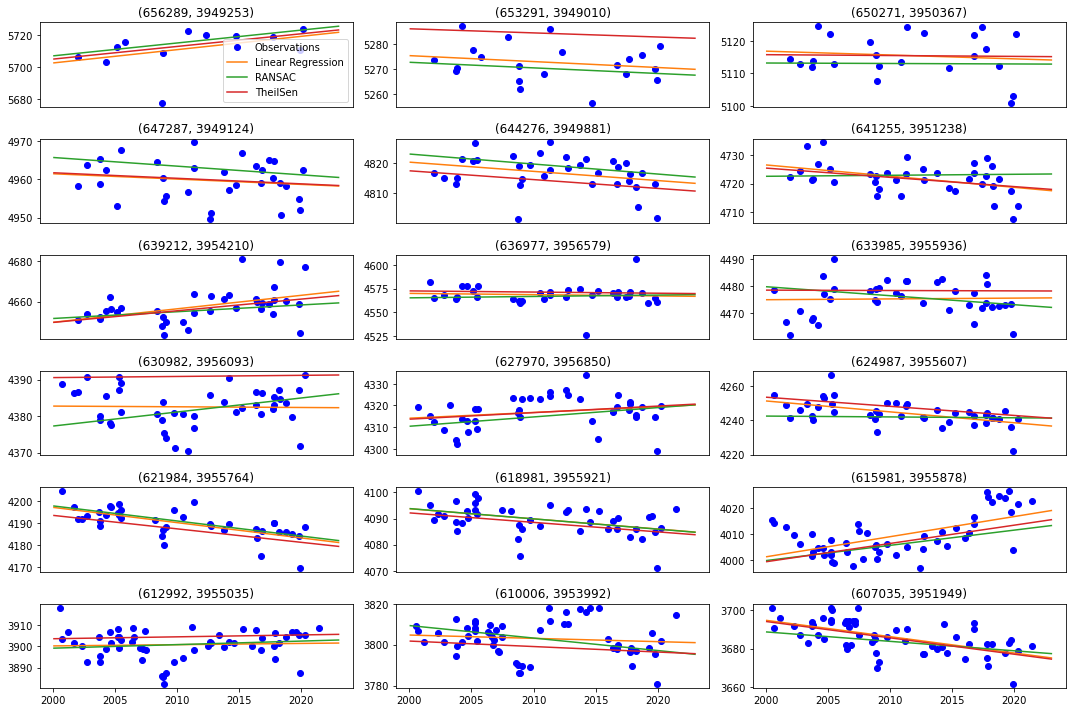

In [36]:
plotting.plot_time_series_gallery(X_train_data,
                                  y_train_data,
                                  predictions_df_list=[LinearReg_df,RANSAC_df,TheilSen_df],
                                  legend_labels = ["Observations",
                                                   "Linear Regression",
                                                   "RANSAC",
                                                   "TheilSen"], 
                                  labels = labels)

### Compare Gaussian Process Regression kernels
- May be possible to use an automated approach to design the kernel.   
- Decompose dominant modes and iteratively evaluate performance on kernels attempting to capture each mode.

#### Glacier Kernel
- Preliminary kernel adaptation from [Hugonnet et al. 2021](https://github.com/iamdonovan/pyddem/blob/master/pyddem/fit_tools.py#L1054)
- Needs more work to fully adapt

In [37]:
glacier_kernel = temporal.GPR_glacier_kernel()

predictions = []
std_predictions = []

for i,v in enumerate(X_train_data):
    gaussian_process_model = temporal.GPR_model(X_train_data[i], y_train_data[i], glacier_kernel, alpha=1e-10)
    mean_prediction, std_prediction = temporal.GPR_predict(gaussian_process_model, X)
    predictions.append(mean_prediction)
    std_predictions.append(std_prediction)
    
GPR_df = pd.DataFrame(predictions).T
GPR_df.index = X

GPR_std_df = pd.DataFrame(std_predictions).T
GPR_std_df.index = X

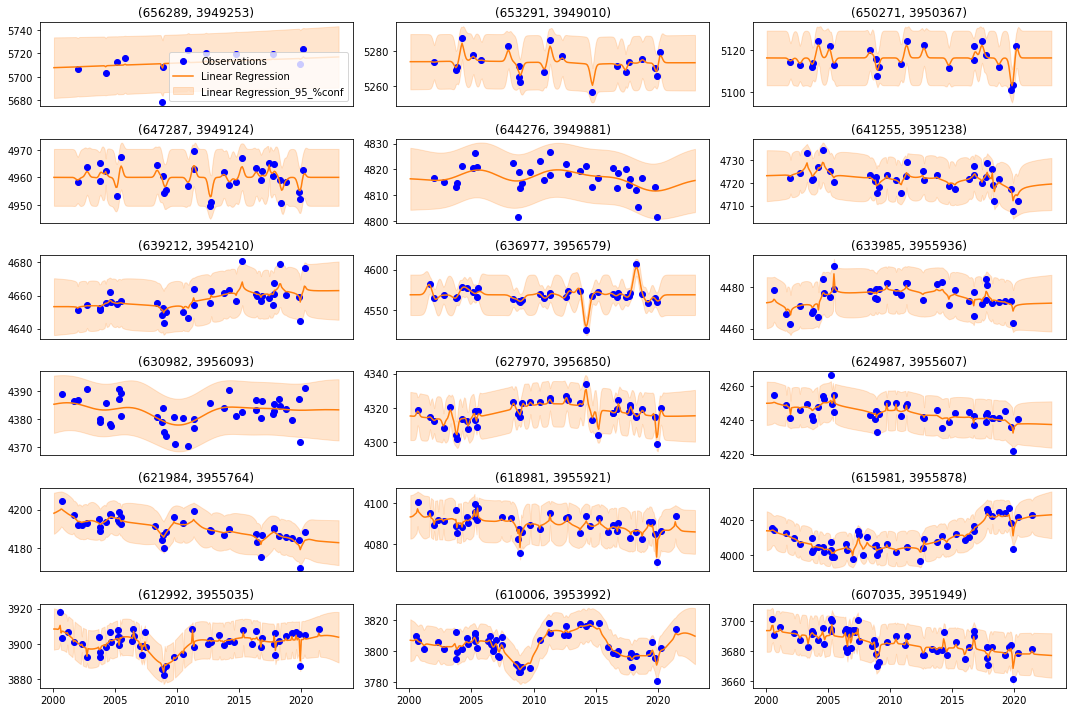

In [38]:
plotting.plot_time_series_gallery(X_train_data,
                                  y_train_data,
                                  predictions_df_list=[GPR_df],
                                  std_df_list=[GPR_std_df],
                                  legend_labels = ["Observations",
                                                   "Linear Regression",
                                                   "RANSAC",
                                                   "TheilSen",
                                                   "GPR"], 
                                  labels = labels)

#### Glacier + Snow Kernel?
- Preliminary kernal adaptation from [Mauna Loa CO2](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py) example


In [39]:
snow_kernel = temporal.GPR_snow_kernel()

predictions = []
std_predictions = []

for i,v in enumerate(X_train_data):
    gaussian_process_model = temporal.GPR_model(X_train_data[i], y_train_data[i], snow_kernel, alpha=1e-10)
    mean_prediction, std_prediction = temporal.GPR_predict(gaussian_process_model, X)
    predictions.append(mean_prediction)
    std_predictions.append(std_prediction)
    
GPR_df = pd.DataFrame(predictions).T
GPR_df.index = X

GPR_std_df = pd.DataFrame(std_predictions).T
GPR_std_df.index = X

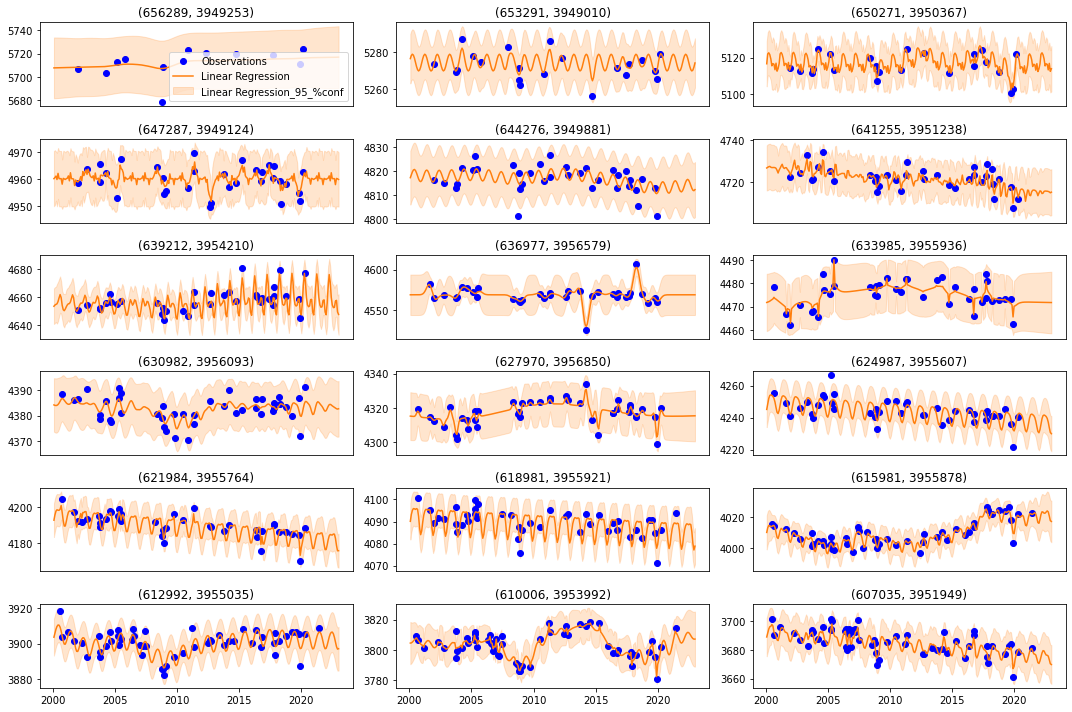

In [40]:
plotting.plot_time_series_gallery(X_train_data,
                                  y_train_data,
                                  predictions_df_list=[GPR_df],
                                  std_df_list=[GPR_std_df],
                                  legend_labels = ["Observations",
                                                   "Linear Regression",
                                                   "RANSAC",
                                                   "TheilSen",
                                                   "GPR"], 
                                  labels = labels)

### Multiprocessing linear regression
- slice the stack for testing

In [10]:
X_train = np.ma.array([utils.date_time_to_decyear(i) for i in datetimes_list]).data
test_stack = ma_stack[:,1500:1550,1700:1750]

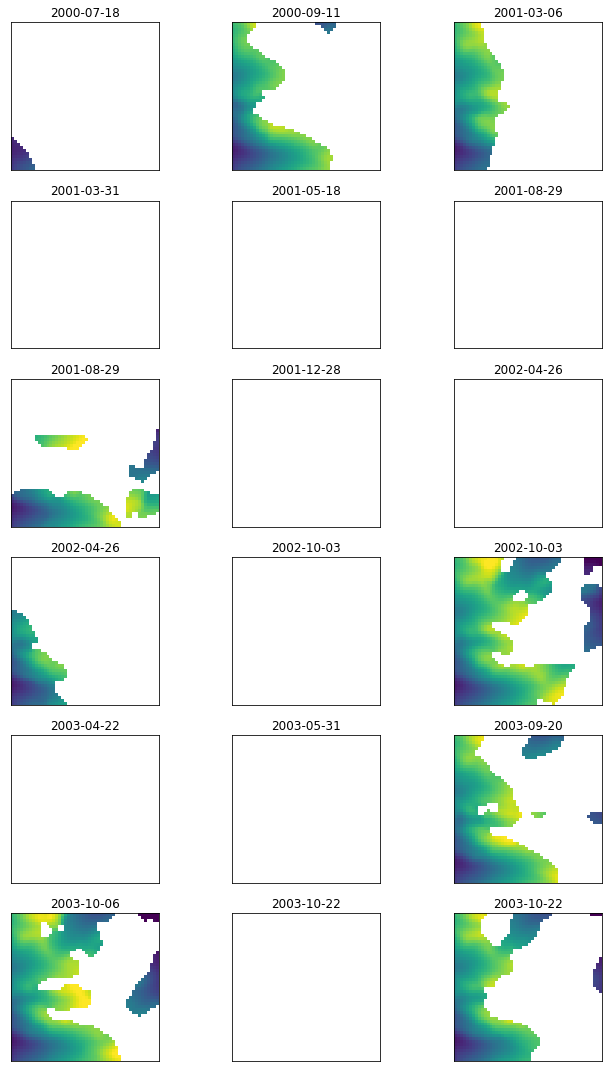

In [11]:
n = 18
plotting.plot_array_gallery(test_stack[:n], dates_list[:n])

#### Get pixel with 3 or more observations

In [43]:
valid_data, valid_mask_2D = temporal.mask_low_count_pixels(test_stack, n_thresh = 3)

#### Run linear model

In [44]:
results = temporal.linreg_run_parallel(X_train, valid_data, method='TheilSen')
results_stack = temporal.linreg_reshape_parallel_results(results, test_stack, valid_mask_2D)

slope = results_stack[0]
intercept = results_stack[1]

prediction_stack = np.ma.array([slope*x+intercept for x in X])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2047/2047 [00:00<00:00, 29054.96it/s]


#### Get labels for predictions dates

In [45]:
X_dates = [utils.decyear_to_date_time(i).date() for i in X]

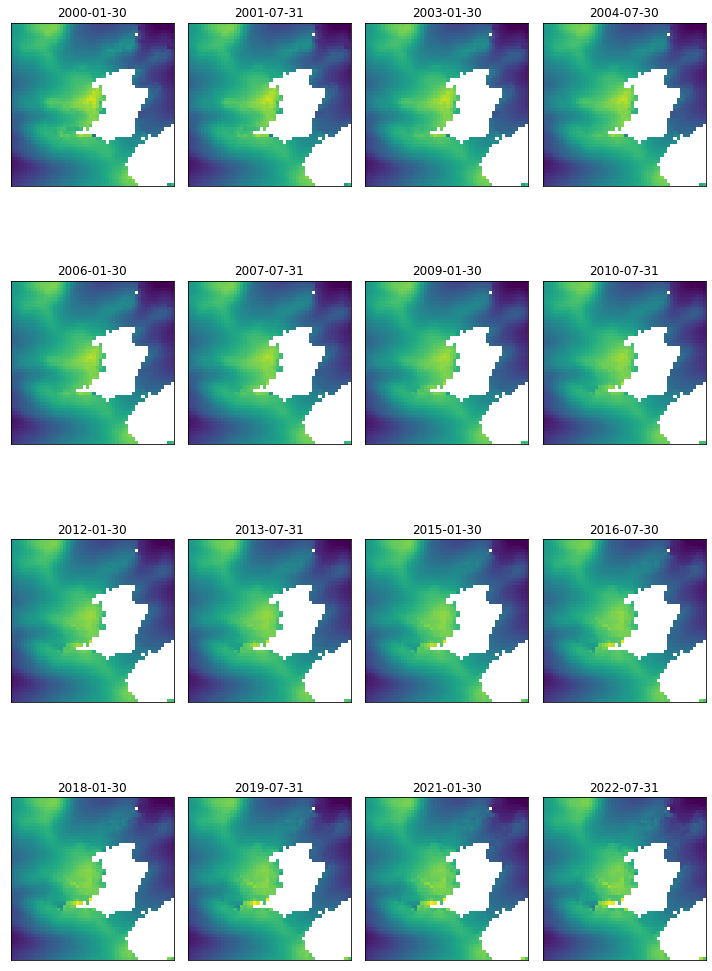

In [46]:
step = 20
plotting.plot_array_gallery(prediction_stack[::n], X_dates[::n])

In [47]:
# plotting.plot_timelapse(prediction_stack[::n], 
#                      titles_list=X_dates[::n])

#### Predict DEM surface at a date


In [48]:
target_date = utils.date_time_to_decyear(datetime.datetime.strptime('2020-07-29','%Y-%m-%d'))
prediction = np.ma.array(slope*target_date+intercept)

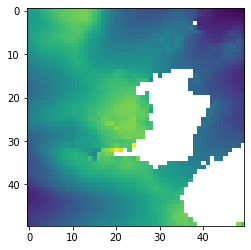

In [53]:
plt.imshow(prediction);

### Multiprocessing GPR
- slice the stack for testing
- potentiall faster implementations [here](https://github.com/zgbkdlm/ssdgp/blob/main/python_notebooks/ssdgp_matern_32_ekfs_tutorial.ipynb) and [here](https://github.com/iamdonovan/pyddem/blob/master/pyddem/fit_tools.py#L1054)

In [43]:
valid_data, valid_mask_2D = temporal.mask_low_count_pixels(test_stack, n_thresh = 3)

In [ ]:
%%time
results = temporal.GPR_run_parallel(X_train, valid_data, X, glacier_kernel)

In [44]:
prediction_stack = temporal.GPR_reshape_parallel_results(results, test_stack, valid_mask_2D)

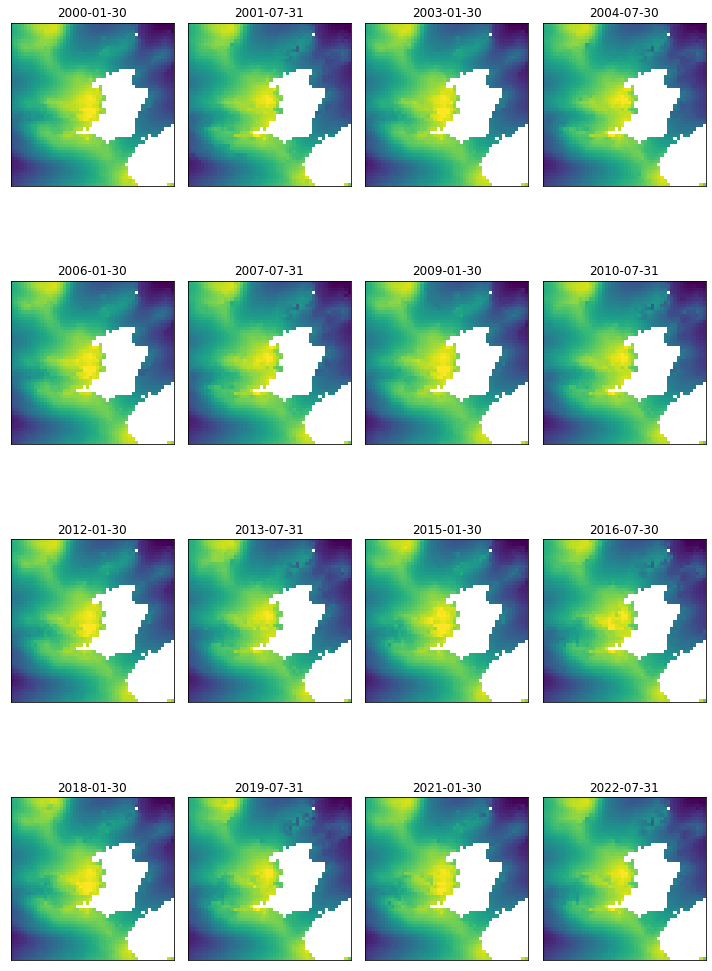

In [45]:
step = 20
plotting.plot_array_gallery(prediction_stack[::n], X_dates[::n])

In [46]:
# plotting.plot_timelapse(prediction_stack[::n], 
#                      titles_list=X_dates[::n])